In [821]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


In [822]:
rgb_img = cv2.imread('test_img/rgb.jpg')
depth_img = cv2.imread('test_img/depth.png',cv2.IMREAD_UNCHANGED)

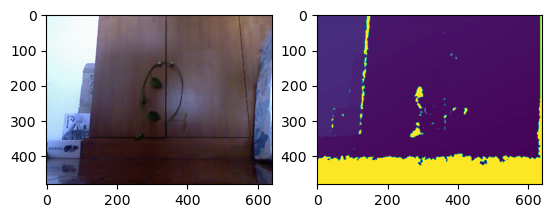

In [823]:
plt.subplots(1,2)
plt.subplot(1,2,1)
plt.imshow(rgb_img[:,:,::-1])
plt.subplot(1,2,2)
plt.imshow(depth_img)

In [824]:
class camera():
    def __init__(self):
        self.ir_intrinsic_matrix = np.array(
            [[590.148060671712, 0, 331.776762806745],
             [0, 586.145968930385, 230.802770705792], [0, 0, 1]])
        self.ir_distortion_matrix = np.array([-0.1093, 0.2668, 0, 0, 0])
        self.rgb_intrinsic_matrix = np.array(
            [[539.020832787886, 0, 325.629602617091],
             [0, 534.861253579807, 256.726953726026], [0, 0, 1]])
        self.rgb_distortion_matrix = np.array(
            [0.147555317189259, -0.303342952312001, 0, 0, 0])
        self.R = np.array(
            [[0.999980636769351, -0.006120529301233, -0.001124814400937],
             [0.006107544444555, 0.999918558578594, -0.011205985497267],
             [0.001193309357038, 0.011198898659239, 0.999936578329645]])
        self.A = np.array([[1, 0, 0, -25.96], [0, 1, 0, -0.9825],
                           [0, 0, 1, 4.4076], [0, 0, 0, 1]])
        self.ir_rgb_extrinsic = np.array([[
            0.999980636769351, -0.00612052930123339, -0.00112481440093692,
            -25.9592777097289
        ],
                                          [
                                              0.00610754444455511,
                                              0.999918558578594,
                                              -0.0112059854972665,
                                              -0.982453053169550
                                          ],
                                          [
                                              0.00119330935703847,
                                              0.0111988986592391,
                                              0.999936578329645,
                                              4.40757685764124
                                          ], [0, 0, 0, 1]])
        img_size = (640, 480)
        return

    def rectify(self):

        return

    def undistortion(self, distorted_img, camera_type):
        # Correcting the distortion
        if camera_type == 'rgb':
            undistorted_img = cv2.undistort(
                distorted_img, self.rgb_intrinsic_matrix,
                self.rgb_distortion_matrix)  # Correcting the distortion
        elif camera_type == 'ir':
            undistorted_img = cv2.undistort(
                distorted_img, self.ir_intrinsic_matrix,
                self.ir_distortion_matrix)  # Correcting the distortion
        return undistorted_img

In [825]:
np.array([[
    0.999980636769351, -0.00612052930123339, -0.00112481440093692,
    -25.9592777097289
],
          [
              0.00610754444455511, 0.999918558578594, -0.0112059854972665,
              -0.982453053169550
          ],
          [
              0.00119330935703847, 0.0111988986592391, 0.999936578329645,
              4.40757685764124
          ], [0, 0, 0, 1]])

array([[ 9.99980637e-01, -6.12052930e-03, -1.12481440e-03,
        -2.59592777e+01],
       [ 6.10754444e-03,  9.99918559e-01, -1.12059855e-02,
        -9.82453053e-01],
       [ 1.19330936e-03,  1.11988987e-02,  9.99936578e-01,
         4.40757686e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [826]:
kinect = camera()

In [827]:
undistorted_depth_img.shape

(480, 640)

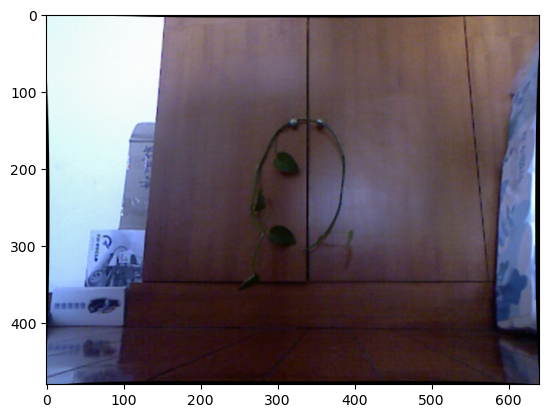

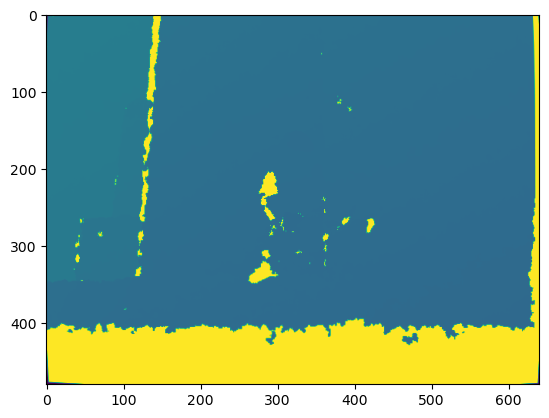

In [828]:
undistorted_rgb_img = kinect.undistortion(rgb_img,'rgb')
plt.imshow( undistorted_rgb_img[:,:,::-1])
plt.show()
undistorted_depth_img = kinect.undistortion(depth_img,'ir')
plt.imshow( undistorted_depth_img[:,:])
plt.show()

In [829]:
np.unique(depth_img)
dist = 0.075*585/(1090-depth_img)*8*1000
dist

array([[1560.        , 1560.        , 1560.        , ...,    5.43520339,
           5.43520339,    5.43520339],
       [1560.        , 1560.        , 1560.        , ...,    5.43520339,
           5.43520339,    5.43520339],
       [1560.        , 1560.        , 1560.        , ...,    5.43520339,
           5.43520339,    5.43520339],
       ...,
       [   5.43520339,    5.43520339,    5.43520339, ...,    5.43520339,
           5.43520339,    5.43520339],
       [   5.43520339,    5.43520339,    5.43520339, ...,    5.43520339,
           5.43520339,    5.43520339],
       [   5.43520339,    5.43520339,    5.43520339, ...,    5.43520339,
           5.43520339,    5.43520339]])

In [830]:
dist[x,y].shape

(640, 480)

In [831]:
cx_ir = kinect.ir_intrinsic_matrix[0,2]
cy_ir = kinect.ir_intrinsic_matrix[1,2]
fx_ir = kinect.ir_intrinsic_matrix[0,0]
fy_ir = kinect.ir_intrinsic_matrix[1,1]

In [832]:
def pixel2world(x,y,intrinsic_matrix, dist):
    cx = intrinsic_matrix[0,2]
    cy = intrinsic_matrix[1,2]
    fx = intrinsic_matrix[0,0]
    fy = intrinsic_matrix[1,1]
    Z = dist[x,y]
    X = (x - cx) * Z / fx
    Y = (y - cy) * Z / fy
    return X, Y ,Z
    

In [833]:
x = np.tile(np.arange(480), (640, 1))

In [834]:
y = np.tile(np.arange(640).reshape(-1, 1), (1, 480))

In [835]:
X,Y,Z = pixel2world(x,y,kinect.ir_intrinsic_matrix, dist)

In [836]:
points_3d = np.dstack((X, Y, Z))


In [837]:
points_3d=points_3d.reshape(-1,3)


In [ ]:
import open3d as o3d
import numpy as np
FOR1 = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1, origin=[0, 0, 0])
# Let's say 'points_3d' is your array of 3D points (numpy array)
# points_3d.shape should be (N, 3), where N is the number of points

# Create an Open3D point cloud object
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points_3d.astype(np.float64))

# Visualize the point cloud
o3d.visualization.draw_geometries([pcd,FOR1])

In [785]:
np.histogram(points_3d[2,:])

(array([117024,      0,      0,      0,      0,      0,      0,      0,
         91330,  98846], dtype=int64),
 array([  5.43520339,  64.38320848, 123.33121356, 182.27921865,
        241.22722373, 300.17522882, 359.1232339 , 418.07123898,
        477.01924407, 535.96724915, 594.91525424]))

In [772]:
points_3d = np.append(points_3d.T, np.ones((1,points_3d.shape[0])),axis=0)

In [725]:
kinect.A.dot(points_3d).T

array([[-25.96305563,  -0.98464018,   4.4130352 ,   1.        ],
       [-25.96304642,  -0.98464018,   4.4130352 ,   1.        ],
       [-25.96303721,  -0.98464018,   4.4130352 ,   1.        ],
       ...,
       [-25.95866251,  -0.97871488,   4.4130352 ,   1.        ],
       [-25.9586533 ,  -0.97871488,   4.4130352 ,   1.        ],
       [-25.95864409,  -0.97871488,   4.4130352 ,   1.        ]])

In [726]:
points_3d.T

array([[-0.00305563, -0.00214018,  0.0054352 ,  1.        ],
       [-0.00304642, -0.00214018,  0.0054352 ,  1.        ],
       [-0.00303721, -0.00214018,  0.0054352 ,  1.        ],
       ...,
       [ 0.00133749,  0.00378512,  0.0054352 ,  1.        ],
       [ 0.0013467 ,  0.00378512,  0.0054352 ,  1.        ],
       [ 0.00135591,  0.00378512,  0.0054352 ,  1.        ]])

In [748]:
rgb_intrinsic_matrix = np.zeros((4,4))
rgb_intrinsic_matrix[:3,:3] = kinect.rgb_intrinsic_matrix
rgb_intrinsic_matrix[3,3] = 1
P = kinect.A.dot(rgb_intrinsic_matrix)

In [749]:
P

array([[539.02083279,   0.        , 325.62960262, -25.96      ],
       [  0.        , 534.86125358, 256.72695373,  -0.9825    ],
       [  0.        ,   0.        ,   1.        ,   4.4076    ],
       [  0.        ,   0.        ,   0.        ,   1.        ]])

In [750]:
np.unique(P.dot(points_3d).astype(int)[1,:])

array([  0,   1,   2,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,
        32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,
        45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,
        58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
        71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
        84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
       123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135,
       136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148,
       149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161,
       162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174,
       175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187,
       188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 19

In [751]:
np.unique(P.dot(points_3d).astype(int)[0,:])

array([-25, -24, -23, -13, -12, -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,
        -3,  -2,  -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
        10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,
        23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,
        36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,
        49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,
        62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,
        75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,
        88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100,
       101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113,
       114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126,
       127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
       140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
       153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 16